In [1]:
import subprocess
import os
import pandas as pd
import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
import seawater as sw
from roms_regrid import *

/tmp/ipykernel_4091772/3005166470.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
HAFRO_path='/home/x-uheede/R/HAFRO/Hafro_cruises.xls'
model_grid_path="/home/x-uheede/S/Iceland2_MARBL_2024_60m/P_INPUT/Iceland2_grid_MAT1.nc"
# Grid parameters, only modify these if grid is made in MATLAB
vert_levels=60
theta_s_model=5
theta_b_model=2
hc_model=300
model_data_path="/anvil/scratch/x-uheede/Iceland2_NOMARBL_2024_NewV/Iceland2_MARBL_2024_his.20240[4][0-14]???????.nc"
months_analysis=[4] # enter the months you want to analyze for the model
# enter the dates you want to analyze for the observations
target_depth_levels=[10] # Specify depth levels of interest
thinner=1 # specify the temporal frequency of data being read (i.e. no need to read in hourly data)


In [3]:
from roms_tools import Grid, ROMSOutput
grid = Grid.from_file(
    model_grid_path
)


2025-12-08 14:14:17 - WARNING - Vertical coordinates (Cs_r, Cs_w) not found in grid file.
2025-12-08 14:14:17 - INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
2025-12-08 14:14:17 - INFO - Total time: 0.004 seconds
2025-12-08 14:14:17 - INFO - ========================================================================================================


In [4]:
#Only run this cell if grid is made in MATLAB
grid.update_vertical_coordinate(N=vert_levels, theta_s=theta_s_model, theta_b=theta_b_model, hc=hc_model, verbose=False)

In [5]:
import xarray as xr
import numpy as np
target_depth_levels=[1,2,3,4,5,7,9,10,12,14,15,16,18,20,26,30,36,40,50,80] # Specify depth levels of interest
# Load ROMS output using your pattern
roms_output = ROMSOutput(
    grid=grid,
    path=[
        model_data_path,
    ],
    use_dask=True,
)

ds = roms_output.regrid(var_names=["u", "v"],depth_levels=target_depth_levels)

In [6]:
u_rg=ds['u'].mean('time').load()
v_rg=ds['v'].mean('time').load()

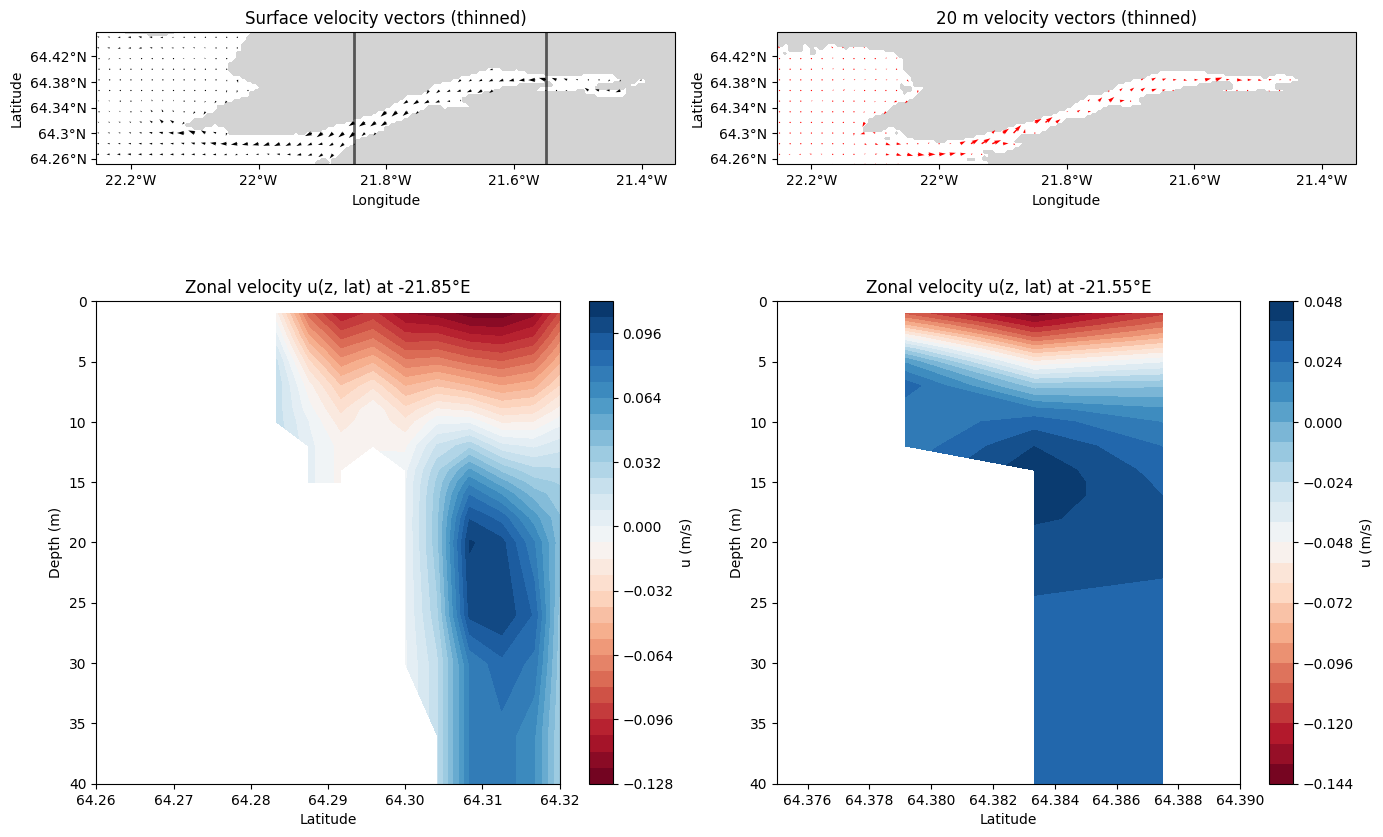

In [10]:
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------
#  Select depths and prepare surface/20 m vector plotting
# -------------------------------------------------------
surface_depth = 0
depth20 = 20

u_surf = u_rg.sel(depth=surface_depth, method="nearest")
v_surf = v_rg.sel(depth=surface_depth, method="nearest")

u_20 = u_rg.sel(depth=depth20, method="nearest")
v_20 = v_rg.sel(depth=depth20, method="nearest")

lon = u_rg.lon
lat = u_rg.lat

# -------------------------------------------------------
# 1) Compute full-resolution land mask (before thinning)
# -------------------------------------------------------
mask_surf_full = np.isnan(u_surf) | np.isnan(v_surf)
mask_200_full  = np.isnan(u_20)   | np.isnan(v_20)

# -------------------------------------------------------
# 2) Thin vectors
# -------------------------------------------------------
step = 4
lon_thin = lon[::step]
lat_thin = lat[::step]

u_surf_thin = u_surf[::step, ::step]
v_surf_thin = v_surf[::step, ::step]

u_200_thin = u_20[::step, ::step]
v_200_thin = v_20[::step, ::step]

# -------------------------------------------------------
#  Data for vertical sections
# -------------------------------------------------------
lonA = 360 - 21.85
lonB = 360 - 21.55

uA = u_rg.sel(lon=lonA, method="nearest")
if "time" in uA.dims:
    uA = uA.isel(time=0)
uA = uA.transpose("depth", "lat")

uB = u_rg.sel(lon=lonB, method="nearest")
if "time" in uB.dims:
    uB = uB.isel(time=0)
uB = uB.transpose("depth", "lat")

depth_vals = uA.depth.values
lat_vals_A = uA.lat.values
lat_vals_B = uB.lat.values

extent_hval = [-22.2543190362897, -21.3469394652069, 
               64.25114671, 64.45802068]

# -------------------------------------------------------
# Plotting using GridSpec
# -------------------------------------------------------
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# ===========================
# Panel 1 — Surface vectors
# ===========================
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent(extent_hval)

# Mask
ax1.contourf(
    lon, lat, mask_surf_full,
    levels=[0.5, 1.5],
    colors=["lightgray"],
    transform=ccrs.PlateCarree(),
    zorder=1
)

# Vectors
ax1.quiver(
    lon_thin, lat_thin,
    u_surf_thin, v_surf_thin,
    transform=ccrs.PlateCarree(), zorder=2
)

# --- NEW: vertical slice lines ---
ax1.plot([lonA-360, lonA-360], [lat.min(), lat.max()], 
         color='black',alpha=0.6, linewidth=2, transform=ccrs.PlateCarree())
ax1.plot([lonB-360, lonB-360], [lat.min(), lat.max()], 
         color='black',alpha=0.6, linewidth=2, transform=ccrs.PlateCarree())

ax1.set_title("Surface velocity vectors (thinned)")
ax1.set_xticks([-22.2, -22.0, -21.8, -21.6, -21.4], crs=ccrs.PlateCarree())
ax1.set_yticks([64.26, 64.30, 64.34, 64.38, 64.42], crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax1.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# ===========================
# Panel 2 — 20 m vectors
# ===========================
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax2.set_extent(extent_hval)

# Mask
ax2.contourf(
    lon, lat, mask_200_full,
    levels=[0.5, 1.5],
    colors=["lightgray"],
    transform=ccrs.PlateCarree(),
    zorder=1
)

# Vectors
ax2.quiver(
    lon_thin, lat_thin,
    u_200_thin, v_200_thin,
    color="red",
    transform=ccrs.PlateCarree(),
    zorder=2
)

# --- NEW: vertical slice lines ---
#ax2.plot([lonA-360, lonA-360], [lat.min(), lat.max()],
#         color='yellow', linewidth=2, transform=ccrs.PlateCarree())
#ax2.plot([lonB-360, lonB-360], [lat.min(), lat.max()],
#         color='yellow', linewidth=2, transform=ccrs.PlateCarree())

ax2.set_title("20 m velocity vectors (thinned)")
ax2.set_xticks([-22.2, -22.0, -21.8, -21.6, -21.4], crs=ccrs.PlateCarree())
ax2.set_yticks([64.26, 64.30, 64.34, 64.38, 64.42], crs=ccrs.PlateCarree())
ax2.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax2.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

# ===========================
# Panel 3 — Vertical section at A
# ===========================
ax3 = fig.add_subplot(gs[1, 0])
cf = ax3.contourf(lat_vals_A, depth_vals, uA, levels=30,cmap='RdBu')
ax3.set_title(f"Zonal velocity u(z, lat) at {lonA-360:.2f}°E")
ax3.set_xlabel("Latitude")
ax3.set_ylabel("Depth (m)")
fig.colorbar(cf, ax=ax3, label="u (m/s)")

ax3.set_ylim(0, 40)
ax3.invert_yaxis()
ax3.set_xlim(64.26, 64.32)

# ===========================
# Panel 4 — Vertical section at B
# ===========================
ax4 = fig.add_subplot(gs[1, 1])
cf = ax4.contourf(lat_vals_B, depth_vals, uB, levels=30, cmap='RdBu')
ax4.set_title(f"Zonal velocity u(z, lat) at {lonB-360:.2f}°E")
ax4.set_xlabel("Latitude")
ax4.set_ylabel("Depth (m)")
fig.colorbar(cf, ax=ax4, label="u (m/s)")

ax4.set_ylim(0, 40)
ax4.invert_yaxis()
ax4.set_xlim(64.375, 64.39)

plt.tight_layout()
plt.show()
